In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import gdown
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import rasterstats
from pprint import pprint
from osgeo import gdal

# import geoprofile
import micro
import gtsa

## Download sample data

In [3]:
# url = 'https://drive.google.com/drive/u/1/folders/1E1FbgeS2YHqnZOsXpbXTIpWhWT1oDR5N'
k13_dem_folder='../data/dems/k13_coreg/'
# # gdown.download_folder(url, output=k13_dem_folder, quiet=False, use_cookies=False)

# url = 'https://drive.google.com/drive/u/1/folders/1NBJ87RWqVEixA7XuN4uvmtjGJ03JIU56'
m14_dem_folder='../data/dems/m14_coreg/'
# gdown.download_folder(url, output=m14_dem_folder, quiet=False, use_cookies=False)

In [4]:
k13_wsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr1/*.tif'))
k13_wsyr1_dem_files = [i.as_posix() for i in k13_wsyr1_dem_files]

k13_dsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/dsyr1/*.tif'))
k13_dsyr1_dem_files = [i.as_posix() for i in k13_dsyr1_dem_files]

k13_wsyr2_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr2/*.tif'))
k13_wsyr2_dem_files = [i.as_posix() for i in k13_wsyr2_dem_files]

m14_wsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr1/*.tif'))
m14_wsyr1_dem_files = [i.as_posix() for i in m14_wsyr1_dem_files]

m14_dsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/dsyr1/*.tif'))
m14_dsyr1_dem_files = [i.as_posix() for i in m14_dsyr1_dem_files]

m14_wsyr2_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr2/*.tif'))
m14_wsyr2_dem_files = [i.as_posix() for i in m14_wsyr2_dem_files]

In [5]:
k13_ortho1 = '/home/adalvis/github/micro_diff/data/orthomosaics/k13/k13_20201109_ortho.tif'
m14_ortho1 = '/home/adalvis/github/micro_diff/data/orthomosaics/m14/m14_20201203_ortho.tif'

## Select analysis ready data
- Assuming SfM and lidar collected on the same date are only used for validation of the SfM data
- Assuming the lidar is always "better" and will thus be used for the quantitative measurements and time series analysis

In [6]:
# KID-13
dsm_files_k13_wsyr1 = k13_wsyr1_dem_files
dsm_files_k13_dsyr1 = k13_dsyr1_dem_files
dsm_files_k13_wsyr2 = k13_wsyr2_dem_files

# MEL-14
dsm_files_m14_wsyr1 = m14_wsyr1_dem_files
dsm_files_m14_dsyr1 = m14_dsyr1_dem_files
dsm_files_m14_wsyr2 = m14_wsyr2_dem_files

## Parse time stamps

#### KID-13 Wet1

In [7]:
strings_k13_wsyr1 = gtsa.io.parse_timestamps(dsm_files_k13_wsyr1, date_string_pattern='_........_')
date_strings_k13_wsyr1 = [x[1:-1] for x in strings_k13_wsyr1]

# ensure chronological sorting
date_strings_k13_wsyr1, dsm_files_k13_wsyr1 = list(zip(*sorted(zip(date_strings_k13_wsyr1, dsm_files_k13_wsyr1))))
date_times_k13_wsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_wsyr1]

list(zip(date_strings_k13_wsyr1, dsm_files_k13_wsyr1))

[('20201109',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20201109_lidar_coreg.tif'),
 ('20201110',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20201110_sfm_coreg.tif'),
 ('20210208',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210208_sfm_coreg.tif'),
 ('20210208',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210208_sfm_coreg_1.tif'),
 ('20210406',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210406_sfm_coreg.tif'),
 ('20210406',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210406_sfm_coreg_1.tif'),
 ('20210513',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210513_sfm_coreg.tif')]

#### KID-13 Dry1

In [8]:
strings_k13_dsyr1 = gtsa.io.parse_timestamps(dsm_files_k13_dsyr1, date_string_pattern='_........_')
date_strings_k13_dsyr1 = [x[1:-1] for x in strings_k13_dsyr1]

# ensure chronological sorting
date_strings_k13_dsyr1, dsm_files_k13_dsyr1 = list(zip(*sorted(zip(date_strings_k13_dsyr1, dsm_files_k13_dsyr1))))
date_times_k13_dsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_dsyr1]

list(zip(date_strings_k13_dsyr1, dsm_files_k13_dsyr1))

[('20210604',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210604_lidar_coreg.tif'),
 ('20210605',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210605_sfm_coreg.tif'),
 ('20210819',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210819_sfm_coreg.tif'),
 ('20210913',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210913_sfm_coreg.tif')]

#### KID-13 Wet2

In [9]:
strings_k13_wsyr2 = gtsa.io.parse_timestamps(dsm_files_k13_wsyr2, date_string_pattern='_........_')
date_strings_k13_wsyr2 = [x[1:-1] for x in strings_k13_wsyr2]

# ensure chronological sorting
date_strings_k13_wsyr2, dsm_files_k13_wsyr2 = list(zip(*sorted(zip(date_strings_k13_wsyr2, dsm_files_k13_wsyr2))))
date_times_k13_wsyr2 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_wsyr2]

list(zip(date_strings_k13_wsyr2, dsm_files_k13_wsyr2))

[('20211007',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20211007_lidar_coreg.tif'),
 ('20211008',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20211008_sfm_coreg.tif'),
 ('20220208',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220208_sfm_coreg.tif'),
 ('20220503',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220503_sfm_coreg.tif'),
 ('20220531',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220531_sfm_coreg.tif')]

#### MEL-14 Wet1

In [10]:
strings_m14_wsyr1 = gtsa.io.parse_timestamps(dsm_files_m14_wsyr1, date_string_pattern='_........_')
date_strings_m14_wsyr1 = [x[1:-1] for x in strings_m14_wsyr1]

# ensure chronological sorting
date_strings_m14_wsyr1, dsm_files_m14_wsyr1 = list(zip(*sorted(zip(date_strings_m14_wsyr1, dsm_files_m14_wsyr1))))
date_times_m14_wsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_wsyr1]

list(zip(date_strings_m14_wsyr1, dsm_files_m14_wsyr1))

[('20201203',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201203_lidar_coreg.tif'),
 ('20201204',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201204_sfm_coreg.tif'),
 ('20210224',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20210224_sfm_coreg.tif')]

#### MEL-14 Dry1

In [11]:
strings_m14_dsyr1 = gtsa.io.parse_timestamps(dsm_files_m14_dsyr1, date_string_pattern='_........_')
date_strings_m14_dsyr1 = [x[1:-1] for x in strings_m14_dsyr1]

# ensure chronological sorting
date_strings_m14_dsyr1, dsm_files_m14_dsyr1 = list(zip(*sorted(zip(date_strings_m14_dsyr1, dsm_files_m14_dsyr1))))
date_times_m14_dsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_dsyr1]

list(zip(date_strings_m14_dsyr1, dsm_files_m14_dsyr1))

[('20210603',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210603_lidar_coreg.tif'),
 ('20210604',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210604_sfm_coreg.tif'),
 ('20210914',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210914_sfm_coreg.tif')]

#### MEL-14 Wet2

In [12]:
strings_m14_wsyr2 = gtsa.io.parse_timestamps(dsm_files_m14_wsyr2, date_string_pattern='_........_')
date_strings_m14_wsyr2 = [x[1:-1] for x in strings_m14_wsyr2]

# ensure chronological sorting
date_strings_m14_wsyr2, dsm_files_m14_wsyr2 = list(zip(*sorted(zip(date_strings_m14_wsyr2, dsm_files_m14_wsyr2))))
date_times_m14_wsyr2 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_wsyr2]

list(zip(date_strings_m14_wsyr2, dsm_files_m14_wsyr2))

[('20220309',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220309_lidar_coreg.tif'),
 ('20220310',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220310_sfm_coreg.tif'),
 ('20220316',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220316_sfm_coreg.tif'),
 ('20220324',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220324_sfm_coreg.tif'),
 ('20220411',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220411_sfm_coreg.tif'),
 ('20220428',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220428_sfm_coreg.tif'),
 ('20220601',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220601_sfm_coreg.tif')]

### Shapefiles for road clip

In [13]:
k13_mask_path = '../data/vectors/kid_mask/roadClip/KID13_roadClip.shp'
m14_mask_path = '../data/vectors/mel_mask/roadClip/MEL14_roadClip.shp'

# grab shapefile crs to write to rasters
k13_crs = gpd.read_file(k13_mask_path).crs
k13_mask_gdf = gpd.read_file(k13_mask_path)

m14_crs = gpd.read_file(m14_mask_path).crs
m14_mask_gdf = gpd.read_file(m14_mask_path)

## Create stacks
- resample to reference DEM grid and save as netcdf

In [14]:
reference_dem_k13_wsyr1 = dsm_files_k13_wsyr1[0]

ds_k13_wsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_wsyr1,
    date_times_k13_wsyr1,
    reference_dem_k13_wsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_wsyr1 = ds_k13_wsyr1.rio.clip(k13_mask_gdf["geometry"])

Resampled 7 of 7 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/wsyr1


In [15]:
k13_ortho = rio.open_rasterio(k13_ortho1).squeeze()
# k13_ortho.rio.write_crs(k13_crs, inplace=True)
k13_ortho_clip = k13_ortho.rio.clip(k13_mask_gdf.geometry)

k13_img = np.dstack((k13_ortho_clip[0], k13_ortho_clip[1], k13_ortho_clip[2]))

/home/adalvis/anaconda3/envs/micro_diff/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


/home/adalvis/anaconda3/envs/micro_diff/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


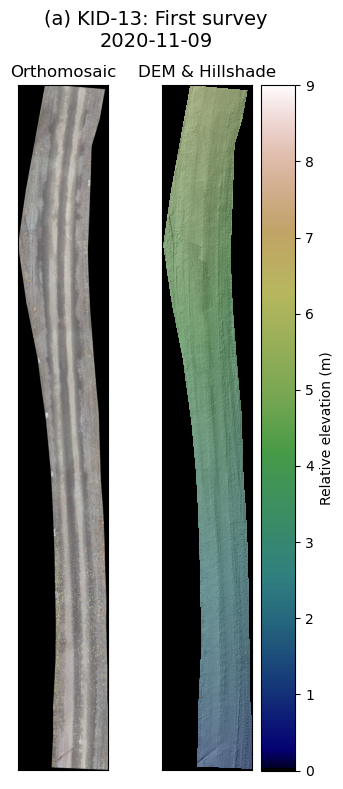

In [16]:
dem_ds = gdal.Open('../data/dems/k13_coreg/KID-13/wsyr1/k13_20201110_sfm_coreg.tif')
dem_ds = gdal.Warp('', dem_ds, cropToCutline=True, cutlineDSName='../data/vectors/kid_mask/roadClip/KID13_roadClip.shp', format='MEM')
#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
producttype = 'hillshade'
#Create a GDAL hillshade dataset in memory
hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', zFactor=2, format='MEM')
#Read the dataset as a NumPy array
hs = hs_ds.ReadAsArray()
hs_mask = np.ma.masked_values(hs, 0)

fig, ax = plt.subplots(1, 2, figsize=(4, 8), layout='tight')
ds_extent= ds_k13_wsyr1.rio.bounds()
m = ax[1].imshow(ds_k13_wsyr1.isel(time=1)['band1']-500, cmap = 'gist_earth',vmin=0,vmax=9)
fig.colorbar(m, label='Relative elevation (m)', ax=ax[1], fraction=0.25)

ax[0].imshow(k13_img)
ax[0].set_title('Orthomosaic', fontsize=12)
ax[1].imshow(hs_mask, cmap='gray')
ax[1].imshow(ds_k13_wsyr1.isel(time=1)['band1']-500, cmap = 'gist_earth', alpha=0.5, vmin=0, vmax=9)
ax[1].set_title('DEM & Hillshade', fontsize=12)
fig.suptitle('(a) KID-13: First survey\n2020-11-09', fontsize=14)
for ax in ax.flat:
    ax.set_facecolor('k')
    xax = ax.get_xaxis()
    xax = xax.set_visible(False)
    yax = ax.get_yaxis()
    yax = yax.set_visible(False)
# plt.savefig('/home/adalvis/github/micro_diff/data/savefigs/Fig4a.png', dpi=300, bbox_inches='tight')
plt.show();

In [17]:
reference_dem_k13_dsyr1 = dsm_files_k13_dsyr1[0]

ds_k13_dsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_dsyr1,
    date_times_k13_dsyr1,
    reference_dem_k13_dsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_dsyr1 = ds_k13_dsyr1.rio.clip(k13_mask_gdf["geometry"])

Resampled 4 of 4 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/dsyr1


In [18]:
reference_dem_k13_wsyr2 = dsm_files_k13_wsyr2[0]

ds_k13_wsyr2 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_wsyr2,
    date_times_k13_wsyr2,
    reference_dem_k13_wsyr2,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_wsyr2 = ds_k13_wsyr2.rio.clip(k13_mask_gdf["geometry"])

Resampled 5 of 5 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/wsyr2


In [19]:
reference_dem_m14_wsyr1 = dsm_files_m14_wsyr1[0]

ds_m14_wsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_wsyr1,
    date_times_m14_wsyr1,
    reference_dem_m14_wsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_wsyr1 = ds_m14_wsyr1.rio.clip(m14_mask_gdf["geometry"])

Resampled 3 of 3 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/wsyr1


In [20]:
m14_ortho = rio.open_rasterio(m14_ortho1).squeeze()
# m14_ortho.rio.write_crs(m14_crs, inplace=True)
m14_ortho_clip = m14_ortho.rio.clip(m14_mask_gdf.geometry)

m14_img = np.dstack((m14_ortho_clip[0], m14_ortho_clip[1], m14_ortho_clip[2]))

/home/adalvis/anaconda3/envs/micro_diff/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


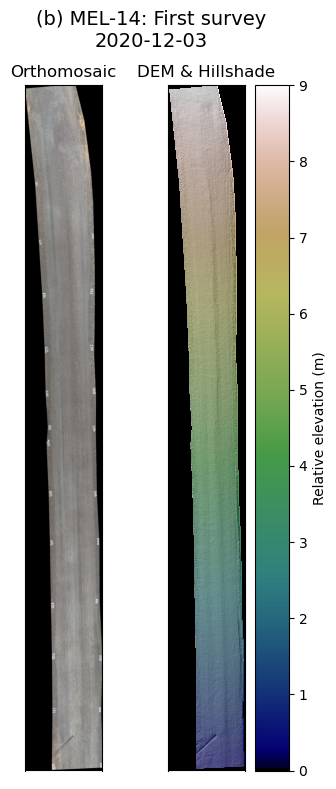

In [21]:
dem_ds = gdal.Open('../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201204_sfm_coreg.tif')
dem_ds = gdal.Warp('', dem_ds, cropToCutline=True, cutlineDSName='../data/vectors/mel_mask/roadClip/MEL14_roadClip.shp', format='MEM')
#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
producttype = 'hillshade'
#Create a GDAL hillshade dataset in memory
hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', zFactor=2, format='MEM')
#Read the dataset as a NumPy array
hs = hs_ds.ReadAsArray()
hs_mask = np.ma.masked_values(hs, 0)

fig, ax = plt.subplots(1, 2, figsize=(4, 8), layout='tight')
ds_extent= ds_m14_wsyr1.rio.bounds()
m = ax[1].imshow(ds_m14_wsyr1.isel(time=1)['band1']-500, cmap = 'gist_earth', vmin=0, vmax=9)
plt.colorbar(m,label='Relative elevation (m)', ax=ax[1],fraction=0.25)

ax[0].imshow(m14_img)
ax[0].set_title('Orthomosaic', fontsize=12)
ax[1].imshow(hs_mask, cmap='gray')
ax[1].imshow(ds_m14_wsyr1.isel(time=1)['band1']-500, cmap = 'gist_earth', alpha=0.5,vmin=0,vmax=9)
ax[1].set_title('DEM & Hillshade', fontsize=12)
fig.suptitle('(b) MEL-14: First survey\n2020-12-03', fontsize=14)
for ax in ax.flat:
    ax.set_facecolor('k')
    xax = ax.get_xaxis()
    xax = xax.set_visible(False)
    yax = ax.get_yaxis()
    yax = yax.set_visible(False)
# plt.savefig('/home/adalvis/github/micro_diff/data/savefigs/Fig4b.png', dpi=300, bbox_inches='tight')
plt.show();

In [22]:
reference_dem_m14_dsyr1 = dsm_files_m14_dsyr1[0]

ds_m14_dsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_dsyr1,
    date_times_m14_dsyr1,
    reference_dem_m14_dsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_dsyr1 = ds_m14_dsyr1.rio.clip(m14_mask_gdf["geometry"])

Resampled 3 of 3 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/dsyr1


In [23]:
reference_dem_m14_wsyr2 = dsm_files_m14_wsyr2[0]

ds_m14_wsyr2 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_wsyr2,
    date_times_m14_wsyr2,
    reference_dem_m14_wsyr2,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_wsyr2 = ds_m14_wsyr2.rio.clip(m14_mask_gdf["geometry"])

Resampled 7 of 7 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/wsyr2


## Save stacks

In [24]:
for i in ds_k13_wsyr1.data_vars:
                try:
                    del ds_k13_wsyr1[i].attrs["grid_mapping"]
                except:
                    pass

ds_k13_wsyr1.to_netcdf('../data/k13_wsyr1.nc')
# ds_k13_wsyr1.isel(time=0).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20201109_lidar_coreg.tif')
# ds_k13_wsyr1.isel(time=1).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20201109_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=2).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210208_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=3).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210406_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=4).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210513_sfm_coreg.tif')

In [25]:
for i in ds_k13_dsyr1.data_vars:
                try:
                    del ds_k13_dsyr1[i].attrs["grid_mapping"]
                except:
                    pass

ds_k13_dsyr1.to_netcdf('../data/k13_dsyr1.nc')
# ds_k13_dsyr1.isel(time=0).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210604_lidar_coreg.tif')
# ds_k13_dsyr1.isel(time=1).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210604_sfm_coreg.tif')
# ds_k13_dsyr1.isel(time=2).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210819_sfm_coreg.tif')
# ds_k13_dsyr1.isel(time=3).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210913_sfm_coreg.tif')

In [26]:
for i in ds_k13_wsyr2.data_vars:
                try:
                    del ds_k13_wsyr2[i].attrs["grid_mapping"]
                except:
                    pass

ds_k13_wsyr2.to_netcdf('../data/k13_wsyr2.nc')
# ds_k13_wsyr2.isel(time=0).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20211007_lidar_coreg.tif')
# ds_k13_wsyr2.isel(time=1).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20211007_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=2).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220208_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=3).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220503_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=4).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220531_sfm_coreg.tif')

In [27]:
for i in ds_m14_wsyr1.data_vars:
                try:
                    del ds_m14_wsyr1[i].attrs["grid_mapping"]
                except:
                    pass

ds_m14_wsyr1.to_netcdf('../data/m14_wsyr1.nc')
# ds_m14_wsyr1.isel(time=0).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20201203_lidar_coreg.tif')
# ds_m14_wsyr1.isel(time=1).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20201203_sfm_coreg.tif')
# ds_m14_wsyr1.isel(time=2).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20210224_sfm_coreg.tif')

In [28]:
for i in ds_m14_dsyr1.data_vars:
                try:
                    del ds_m14_dsyr1[i].attrs["grid_mapping"]
                except:
                    pass

ds_m14_dsyr1.to_netcdf('../data/m14_dsyr1.nc')
# ds_m14_dsyr1.isel(time=0).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210603_lidar_coreg.tif')
# ds_m14_dsyr1.isel(time=1).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210603_sfm_coreg.tif')
# ds_m14_dsyr1.isel(time=2).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210914_sfm_coreg.tif')

In [29]:
for i in ds_m14_wsyr2.data_vars:
                try:
                    del ds_m14_wsyr2[i].attrs["grid_mapping"]
                except:
                    pass

ds_m14_wsyr2.to_netcdf('../data/m14_wsyr2.nc')
# ds_m14_wsyr2.isel(time=0).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220309_lidar_coreg.tif')
# ds_m14_wsyr2.isel(time=1).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220309_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=2).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220316_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=3).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220324_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=4).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220411_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=5).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220428_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=6).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220601_sfm_coreg.tif')

## Compute differences for stack

In [30]:
ds_diff_k13_wsyr1_sfm = ds_k13_wsyr1['band1']- ds_k13_wsyr1['band1'].isel(time=1)

ds_diff_k13_dsyr1_sfm = ds_k13_dsyr1['band1']- ds_k13_dsyr1['band1'].isel(time=1)

ds_diff_k13_wsyr2_sfm = ds_k13_wsyr2['band1']- ds_k13_wsyr2['band1'].isel(time=1)

ds_diff_m14_wsyr1_sfm = ds_m14_wsyr1['band1']- ds_m14_wsyr1['band1'].isel(time=1)

ds_diff_m14_dsyr1_sfm = ds_m14_dsyr1['band1']- ds_m14_dsyr1['band1'].isel(time=1)

ds_diff_m14_wsyr2_sfm = ds_m14_wsyr2['band1']- ds_m14_wsyr2['band1'].isel(time=1)

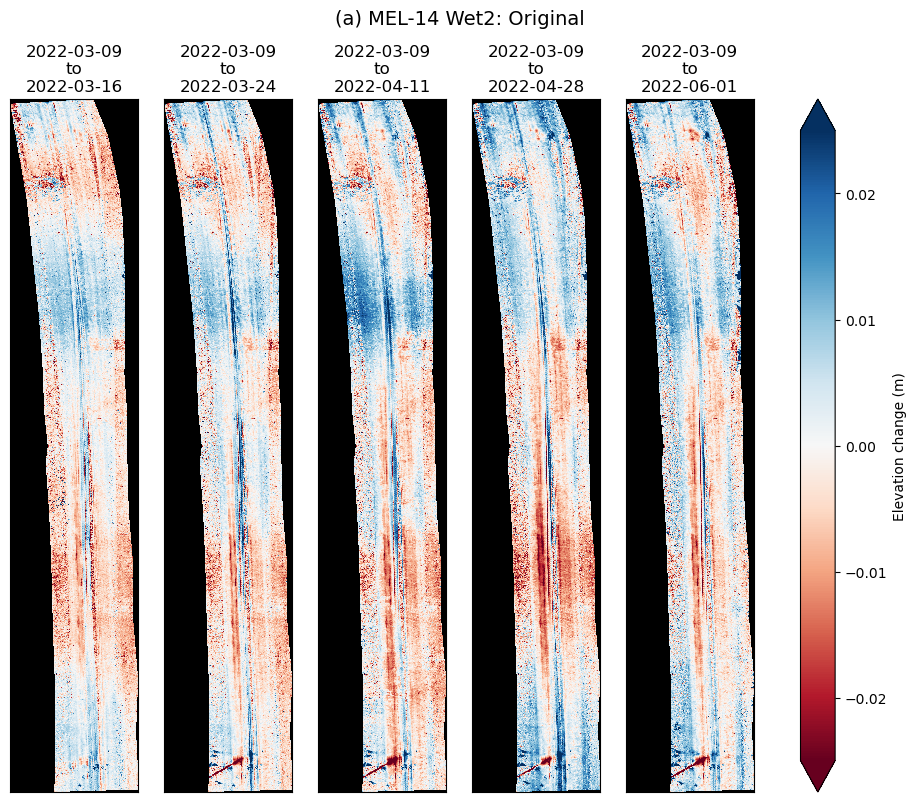

In [31]:
fig, ax = plt.subplots(1, 5, figsize=(12,9))
ds_extent= ds_diff_m14_wsyr2_sfm.rio.bounds()
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.025, vmax=0.025))
fig.colorbar(sm, label='Elevation change (m)', extend='both', ax=ax)

ds_diff_m14_wsyr2_sfm.isel(time=2).plot.imshow(ax=ax[0], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent=ds_extent)
ax[0].set_title('2022-03-09\nto\n2022-03-16', fontsize=12)
ax[0].set_facecolor('k')


ds_diff_m14_wsyr2_sfm.isel(time=3).plot.imshow(ax=ax[1], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[1].set_title('2022-03-09\nto\n2022-03-24', fontsize=12)
ax[1].set_facecolor('k')


ds_diff_m14_wsyr2_sfm.isel(time=4).plot.imshow(ax=ax[2], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[2].set_title('2022-03-09\nto\n2022-04-11', fontsize=12)
ax[2].set_facecolor('k')

ds_diff_m14_wsyr2_sfm.isel(time=5).plot.imshow(ax=ax[3], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[3].set_title('2022-03-09\nto\n2022-04-28', fontsize=12)
ax[3].set_facecolor('k')

ds_diff_m14_wsyr2_sfm.isel(time=6).plot.imshow(ax=ax[4], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[4].set_title('2022-03-09\nto\n2022-06-01', fontsize=12)
ax[4].set_facecolor('k')

for ax in ax.flat:
    ax.set(xlim=(4989.05,4998.025))
    # ax.plot([4989,4998.05],[5001.12+8.16,5001.12+8.16],'--', color='darkgray')
    xax = ax.get_xaxis()
    xax = xax.set_visible(False)
    yax = ax.get_yaxis()
    yax = yax.set_visible(False)


fig.suptitle('(a) MEL-14 Wet2: Original', fontsize=14)
# plt.savefig('/home/adalvis/github/micro_diff/data/savefigs/Fig5a.png', dpi=300, bbox_inches='tight')
plt.show();

## Apply HPGF to stacked dataset

In [32]:
sigma = 50
for i in range(0,5):
    globals()[f'ds_diff_smooth{i}_k13_wsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

ds_diff_k13_wsyr1_sfm = ds_diff_k13_wsyr1_sfm - [ds_diff_smooth0_k13_wsyr1_sfm, \
    ds_diff_smooth1_k13_wsyr1_sfm, ds_diff_smooth2_k13_wsyr1_sfm,\
    ds_diff_smooth3_k13_wsyr1_sfm, ds_diff_smooth4_k13_wsyr1_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [33]:
for i in range(0,4):
    globals()[f'ds_diff_smooth{i}_k13_dsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_dsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

ds_diff_k13_dsyr1_sfm = ds_diff_k13_dsyr1_sfm - [ds_diff_smooth0_k13_dsyr1_sfm, \
    ds_diff_smooth1_k13_dsyr1_sfm, ds_diff_smooth2_k13_dsyr1_sfm,\
    ds_diff_smooth3_k13_dsyr1_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [34]:
for i in range(0,5):
    globals()[f'ds_diff_smooth{i}_k13_wsyr2_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr2_sfm.isel(time=i).values, sigma = sigma, origmask=True)

ds_diff_k13_wsyr2_sfm = ds_diff_k13_wsyr2_sfm - [ds_diff_smooth0_k13_wsyr2_sfm, \
    ds_diff_smooth1_k13_wsyr2_sfm, ds_diff_smooth2_k13_wsyr2_sfm,\
    ds_diff_smooth3_k13_wsyr2_sfm, ds_diff_smooth4_k13_wsyr2_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [35]:
sigma = 50
for i in range(0,3):
    globals()[f'ds_diff_smooth{i}_m14_wsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

ds_diff_m14_wsyr1_sfm = ds_diff_m14_wsyr1_sfm - [ds_diff_smooth0_m14_wsyr1_sfm, \
    ds_diff_smooth1_m14_wsyr1_sfm, ds_diff_smooth2_m14_wsyr1_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [36]:
sigma = 50
for i in range(0,3):
    globals()[f'ds_diff_smooth{i}_m14_dsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_dsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

ds_diff_m14_dsyr1_sfm = ds_diff_m14_dsyr1_sfm - [ds_diff_smooth0_m14_dsyr1_sfm, \
    ds_diff_smooth1_m14_dsyr1_sfm, ds_diff_smooth2_m14_dsyr1_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [37]:
sigma = 50
for i in range(0,7):
    globals()[f'ds_diff_smooth{i}_m14_wsyr2_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr2_sfm.isel(time=i).values, sigma = sigma, origmask=True)


ds_diff_m14_wsyr2_sfm = ds_diff_m14_wsyr2_sfm - [ds_diff_smooth0_m14_wsyr2_sfm, \
    ds_diff_smooth1_m14_wsyr2_sfm, ds_diff_smooth2_m14_wsyr2_sfm,\
    ds_diff_smooth3_m14_wsyr2_sfm, ds_diff_smooth4_m14_wsyr2_sfm,\
    ds_diff_smooth5_m14_wsyr2_sfm, ds_diff_smooth6_m14_wsyr2_sfm]

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


## Plot difference maps

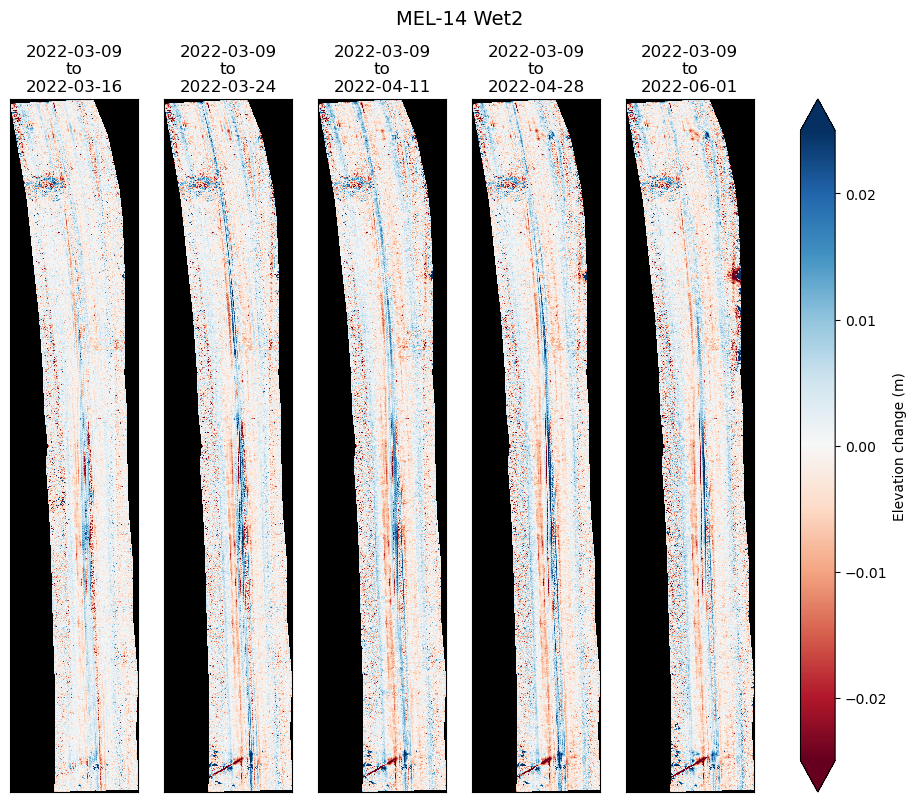

In [38]:
fig, ax = plt.subplots(1, 5, figsize=(12,9))
ds_extent= ds_diff_m14_wsyr2_sfm.rio.bounds()
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.025, vmax=0.025))
fig.colorbar(sm, label='Elevation change (m)', extend='both', ax=ax)

ds_diff_m14_wsyr2_sfm.isel(time=2).plot.imshow(ax=ax[0], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent=ds_extent)
ax[0].set_title('2022-03-09\nto\n2022-03-16', fontsize=12)
ax[0].set_facecolor('k')


ds_diff_m14_wsyr2_sfm.isel(time=3).plot.imshow(ax=ax[1], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[1].set_title('2022-03-09\nto\n2022-03-24', fontsize=12)
ax[1].set_facecolor('k')


ds_diff_m14_wsyr2_sfm.isel(time=4).plot.imshow(ax=ax[2], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[2].set_title('2022-03-09\nto\n2022-04-11', fontsize=12)
ax[2].set_facecolor('k')

ds_diff_m14_wsyr2_sfm.isel(time=5).plot.imshow(ax=ax[3], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[3].set_title('2022-03-09\nto\n2022-04-28', fontsize=12)
ax[3].set_facecolor('k')

ds_diff_m14_wsyr2_sfm.isel(time=6).plot.imshow(ax=ax[4], cmap='RdBu',\
    add_colorbar=False, vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[4].set_title('2022-03-09\nto\n2022-06-01', fontsize=12)
ax[4].set_facecolor('k')

for ax in ax.flat:
    ax.set(xlim=(4989.05,4998.025))
    # ax.plot([4989,4998.05],[5001.12+8.16,5001.12+8.16],'--', color='darkgray')
    xax = ax.get_xaxis()
    xax = xax.set_visible(False)
    yax = ax.get_yaxis()
    yax = yax.set_visible(False)

# fig.suptitle('(b) MEL-14 Wet2: Filtered', fontsize=14)
fig.suptitle('MEL-14 Wet2', fontsize=14)
# plt.savefig('/home/adalvis/github/micro_diff/data/savefigs/Fig5b_new.png', dpi=600, bbox_inches='tight')
plt.show();

In [39]:
ds_diff_k13_wsyr1_sfm.to_netcdf('../data/k13_wsyr1_diff_sfm.nc')
ds_diff_k13_dsyr1_sfm.to_netcdf('../data/k13_dsyr1_diff_sfm.nc')
ds_diff_k13_wsyr2_sfm.to_netcdf('../data/k13_wsyr2_diff_sfm.nc')

In [40]:
ds_diff_m14_wsyr1_sfm.to_netcdf('../data/m14_wsyr1_diff_sfm.nc')
ds_diff_m14_dsyr1_sfm.to_netcdf('../data/m14_dsyr1_diff_sfm.nc')
ds_diff_m14_wsyr2_sfm.to_netcdf('../data/m14_wsyr2_diff_sfm.nc')